# Recommendation Chatbot API: Evaluation

Usign **llama3:instruct** LLM.

In [1]:
%%capture output
%load_ext autoreload
%autoreload 2

In [10]:
import sys
import os

BASE_PATH         = '../..'
API_PATH          = f'{BASE_PATH}/chat-bot-api'
LIB_PATH          = f'{BASE_PATH}/lib'
DATASET_PATH      = f'{BASE_PATH}/datasets'
METRICS_PATH      = f'{BASE_PATH}/metrics'
EVAL_METRICS_PATH = f'{METRICS_PATH}/llama3-evaluation-metrics.dt'
RUN_EVALUATION    = False

os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'

sys.path.append(LIB_PATH)
sys.path.append(API_PATH)

In [3]:
import logging
import os
import pytorch_common.util as pu
import util as ut
from client import RecChatBotV1ApiClient
from models import EvaluationStateFactory, EvaluationState, ModelEvaluator

<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
def on_file(file_path, format='%(asctime)s - %(levelname)s - %(message)s'):
    handler = logging.FileHandler(file_path)
    handler.setFormatter(logging.Formatter(format))
    return handler


pu.LoggerBuilder() \
    .handler(on_file('./evaluation.log'))\
    .on_console() \
    .build()

<RootLogger root (INFO)>

In [12]:
class ItemIdsResolver:
    def __init__(self):
        self.item_ids = []

    def __call__(self):
        if len(self.item_ids) == 0:
            api_client = RecChatBotV1ApiClient()
            self.item_ids = [int(item['id']) for item in api_client.items(all=True)]
    
        return self.item_ids

item_ids_resolver = ItemIdsResolver()

**Step 1**: Load interactions test set and items data.

In [5]:
interactions_test_set = ut.load_df(f'{DATASET_PATH}/interactions_test_set.json')
items                 = ut.load_df(f'{DATASET_PATH}/pre-processed-movies.json')

**Step 2**: Create evaluation state. 

* **EvaluationState** creates user profiles into **Chatbot API** from evaluation interactions.
* Register each user session data required to perform al evaluation metrics.
* Contains all data required to manage the evalauton process, like model hperparams, plot interval, etc..

In [ ]:
if os.path.exists(EVAL_METRICS_PATH):
    logging.info('loading...')
    evaluation_state = EvaluationState.load(EVAL_METRICS_PATH)
    
    evaluation_state.max_patience= {
        20  : 5,
        100 : 6,
        200 : 7
    }
else:
    logging.info('creating...')
    evaluation_state = EvaluationStateFactory.create(
        api_client            = RecChatBotV1ApiClient(),
        interactions_test_set = interactions_test_set,
        items                 = items,
        recommendation_size   = 5,
        path                  = EVAL_METRICS_PATH,
        max_patience          = {
        20  : 5,
        100 : 6,
        200 : 7
        },
        plot_interval         = 5,
        hyper_params          = {
            'llm'                                   : 'llama3:instruct',
                                                    # llama3:instruct
                                                    # llama2:7b-chat
                                                    # mistral:instruct
            'retry'                                 : 1,
            'plain'                                 : False,
            'include_metadata'                      : True,
            'rag': {
                'shuffle'                           : False,
                'candidates_limit'                  : 100,
                'llm_response_limit'                : 100,
                'recommendations_limit'             : 10,
                'similar_items_augmentation_limit'  : 1,
                'not_seen'                          : True
            },
            'collaborative_filtering': {
                'shuffle'                           : False,
                'candidates_limit'                  : 50,
                'llm_response_limit'                : 50,
                'recommendations_limit'             : 10,
                'similar_items_augmentation_limit'  : 2,
                'text_query_limit'                  : 5000,
                'k_sim_users'                       : 10,
                'random_selection_items_by_user'    : 0.5,
                'max_items_by_user'                 : 10,
                'min_rating_by_user'                : 3.5,
                'not_seen'                          : True,
                'rank_criterion'                    : 'user_sim_weighted_pred_rating_score'
                                                    # user_sim_weighted_rating_score
                                                    # user_item_sim
                                                    # pred_user_rating
            }
        },
        verbose = True
    )

**Step 3**: Perform chatbot API evaluation process.
* Simulate user interaciton with API.
* A user requests movie recommendations that previously has rated.
* It process register recomemndations with result rating and user rating.
* It data is user to perform all metrics.

In [ ]:
evaluator = ModelEvaluator(
    evaluation_state      = evaluation_state, 
    interactions_test_set = interactions_test_set,
    items                 = items,
    path                  = EVAL_METRICS_PATH,
    api_client            = RecChatBotV1ApiClient()
)

2024-09-01 20:58:16,575 - INFO - Sessions: 135
2024-09-01 20:58:16,575 - INFO - Max Session Steps Reached: 22
2024-09-01 20:58:16,606 - INFO - Sessions count >= 30 rated items: 50
2024-09-01 20:58:16,608 - INFO - Total Session Steps: 1325
2024-09-01 20:58:16,620 - INFO - Mean NDCG: 0.97
2024-09-01 20:58:16,624 - INFO - Mean Average Precision: 0.47
2024-09-01 20:58:16,627 - INFO - Mean Reciprocal Rank: 0.84
2024-09-01 20:58:16,634 - INFO - Mean Recall: 0.55
2024-09-01 20:58:16,637 - INFO - Catalog Coverage: 0.14


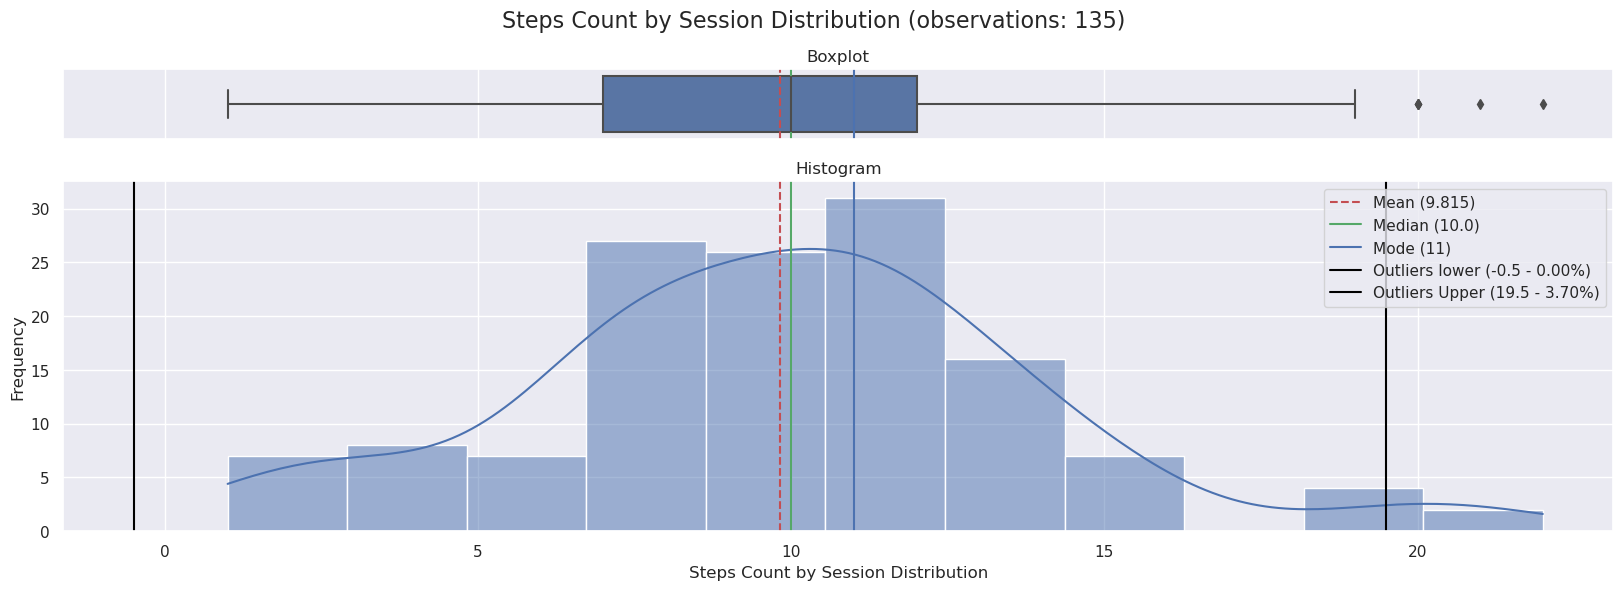

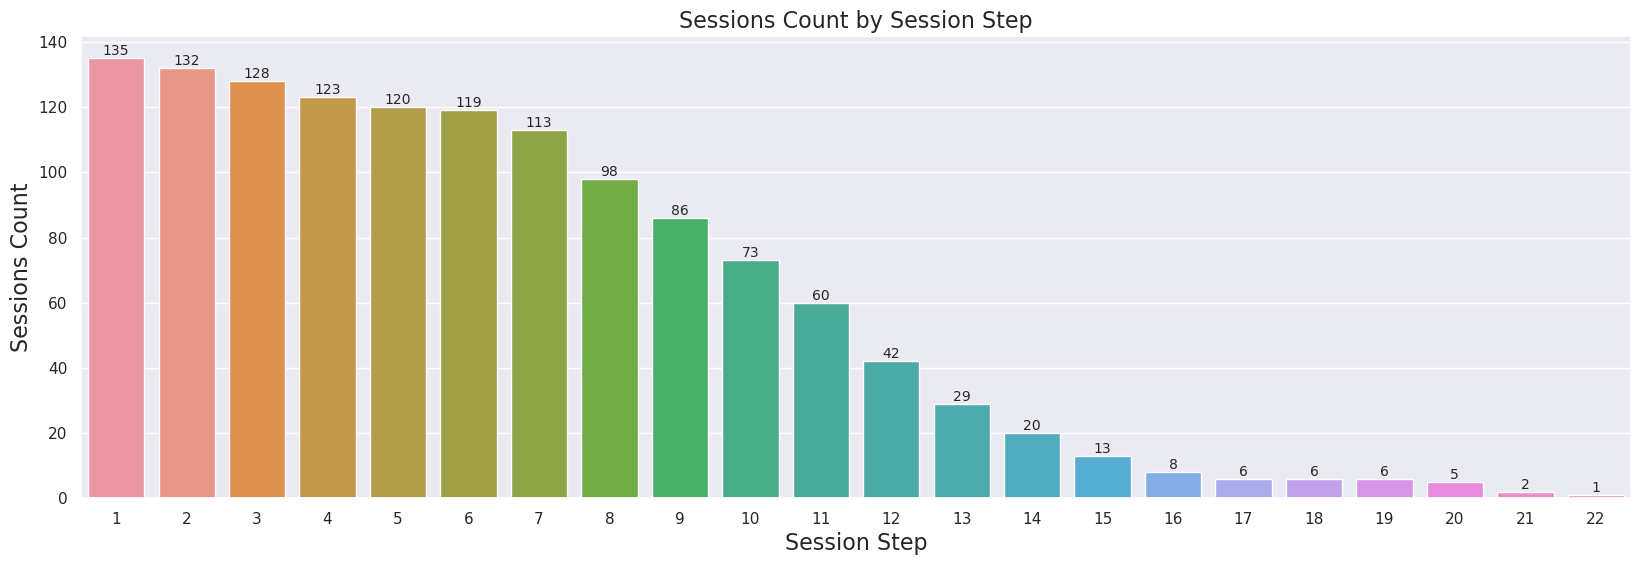

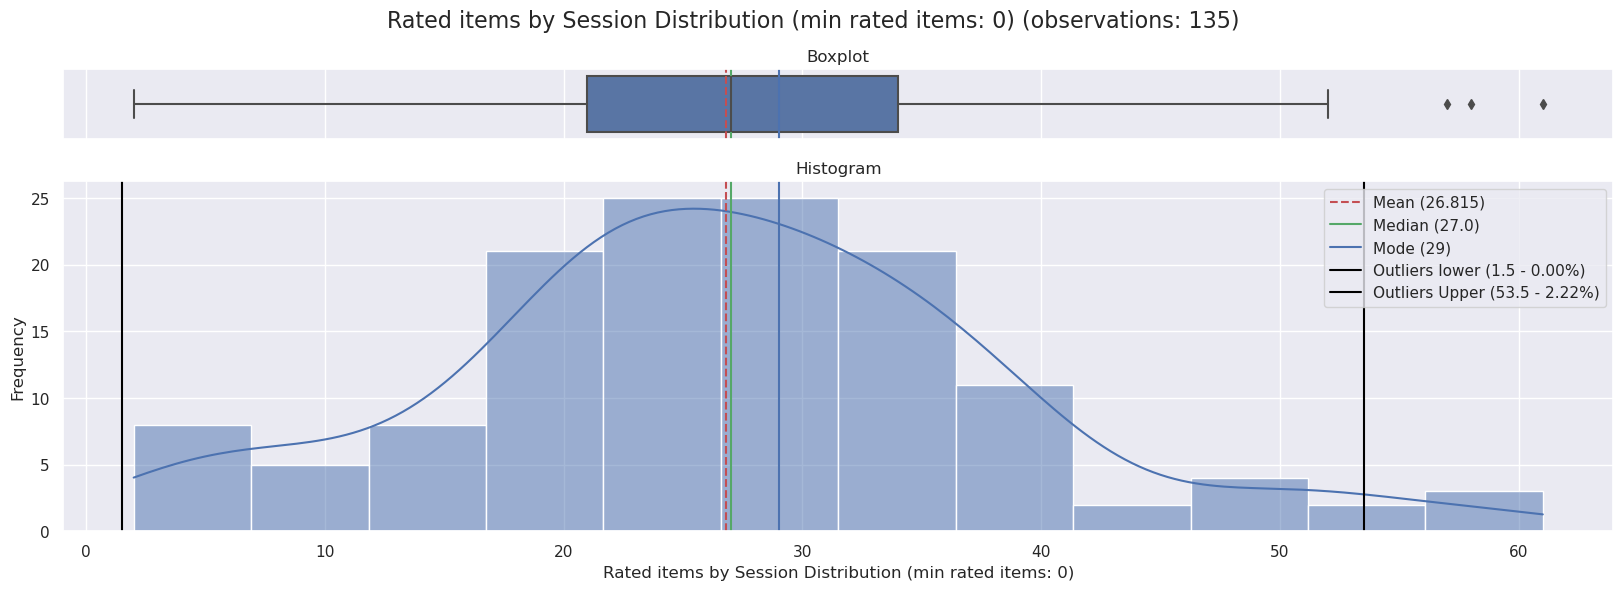

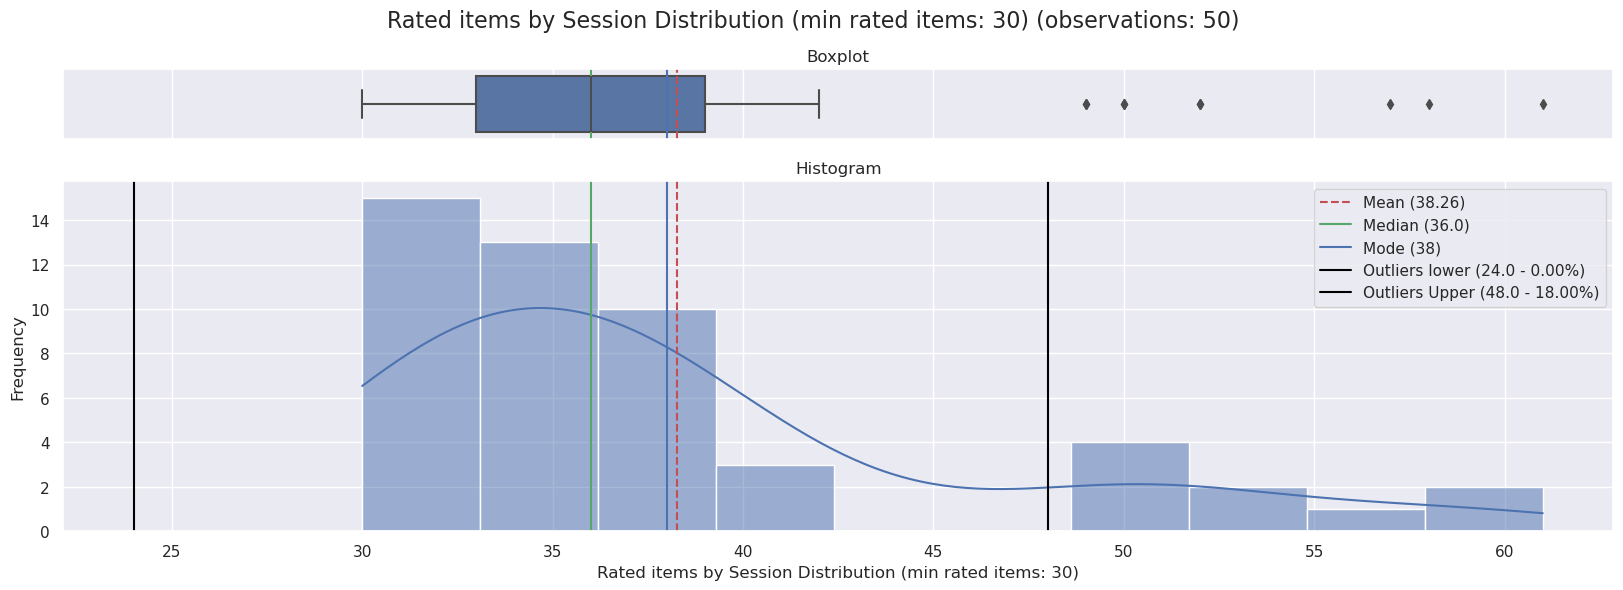

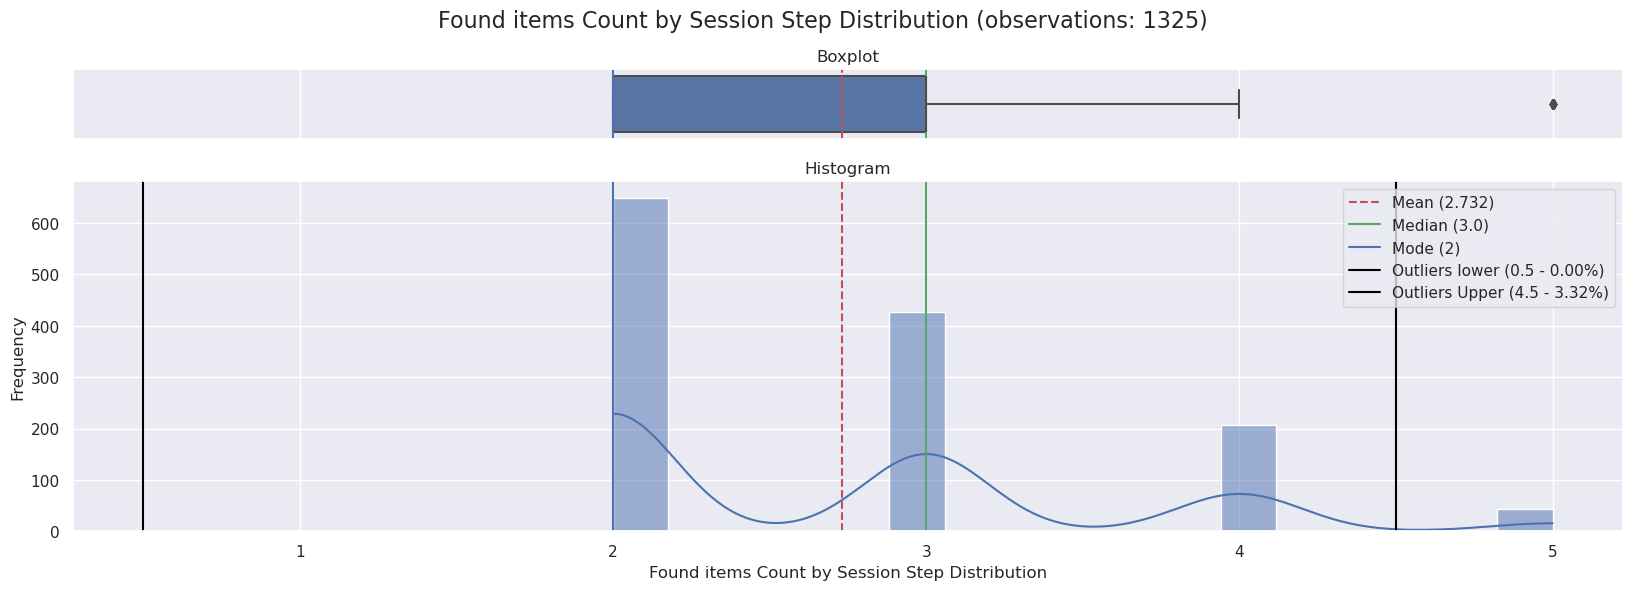

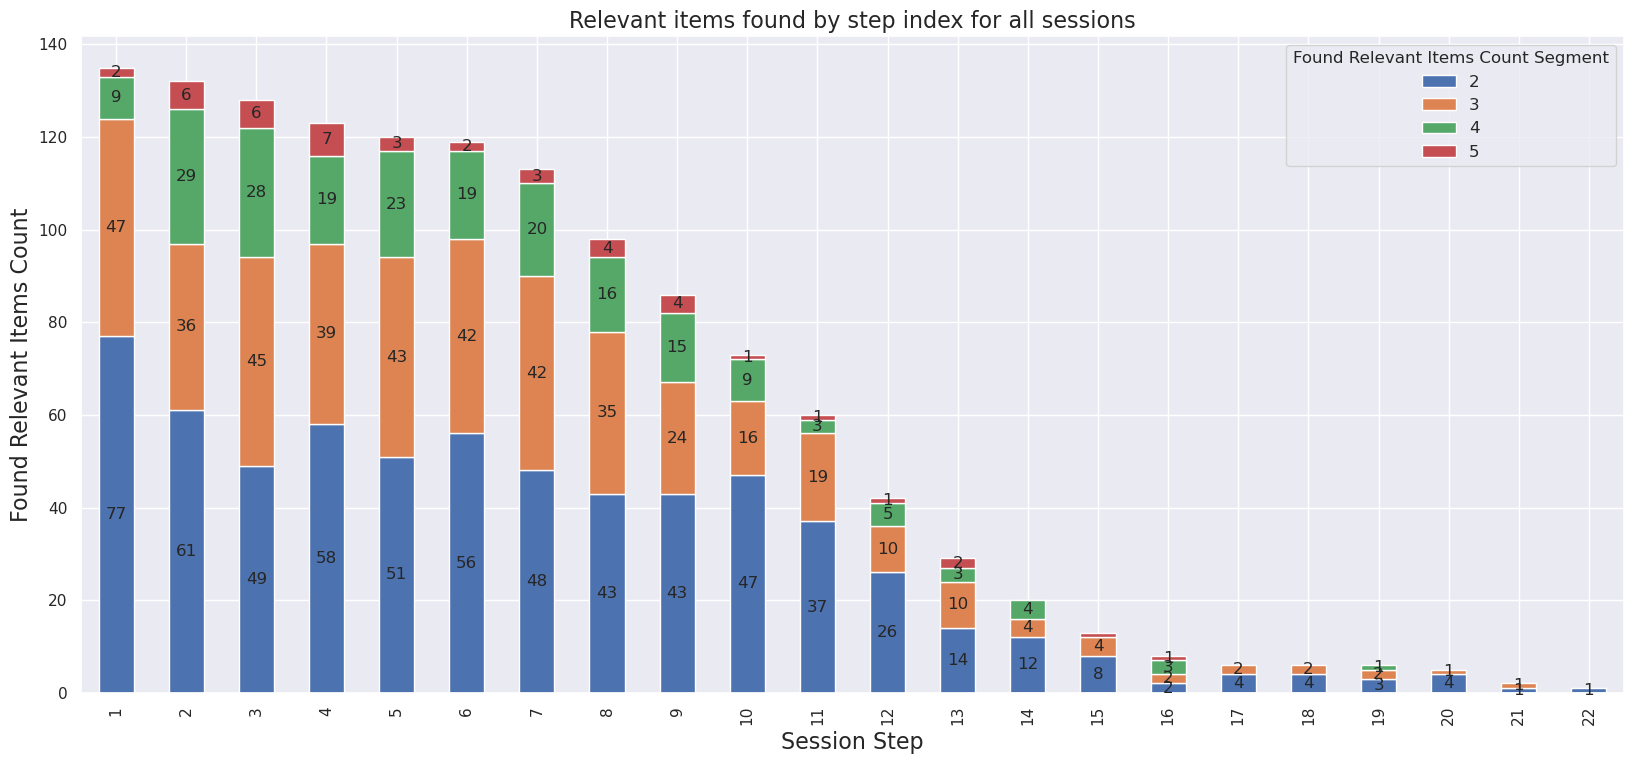

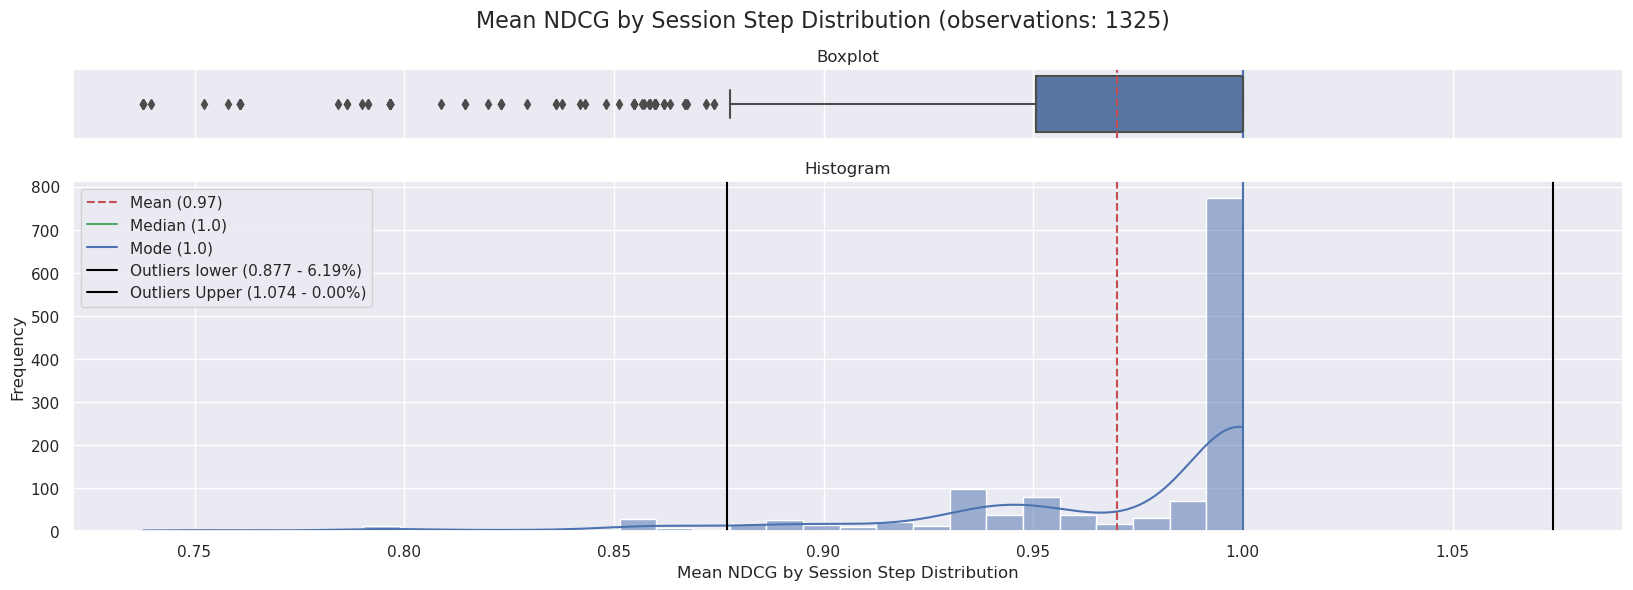

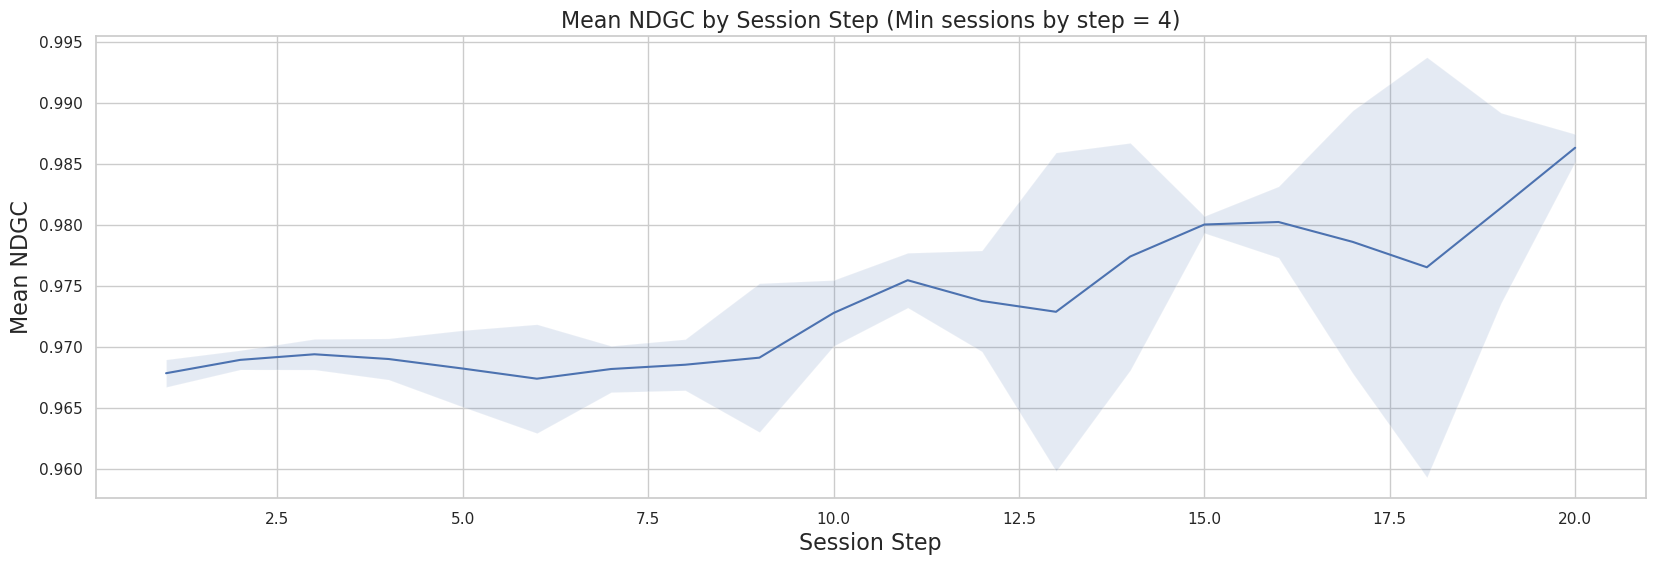

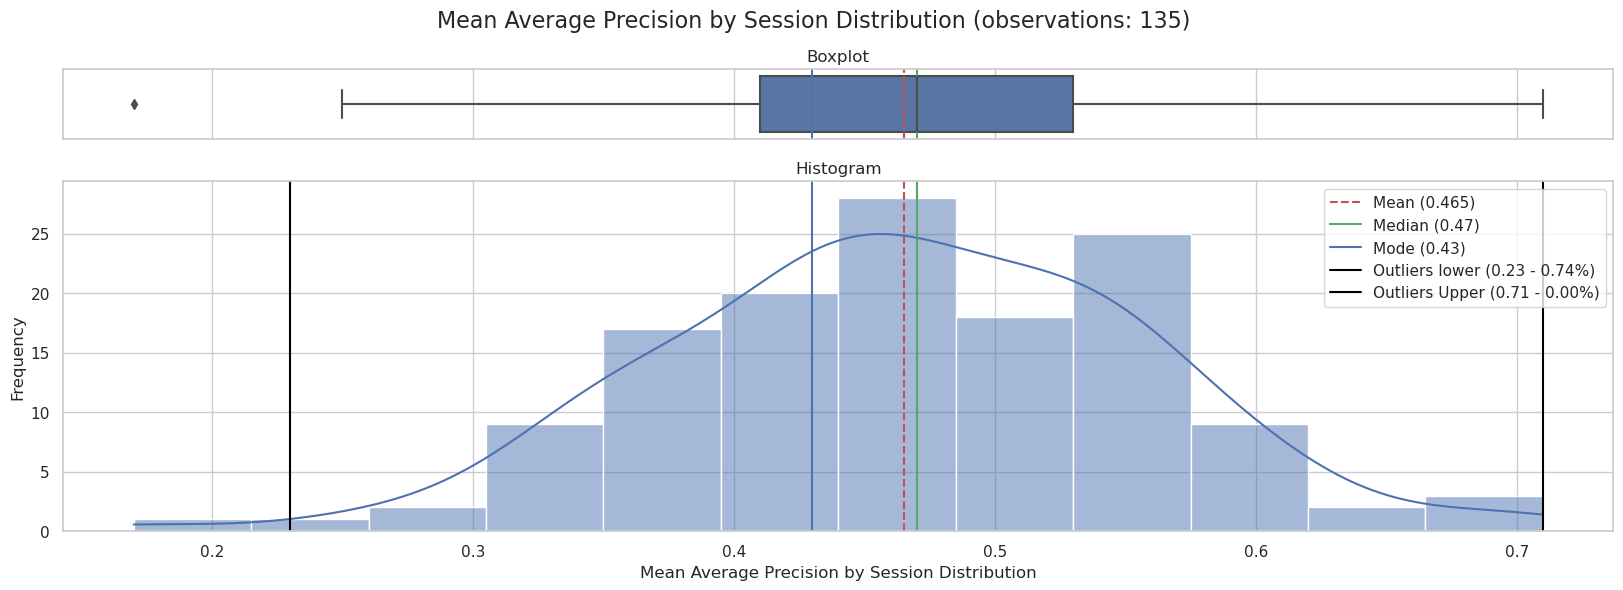

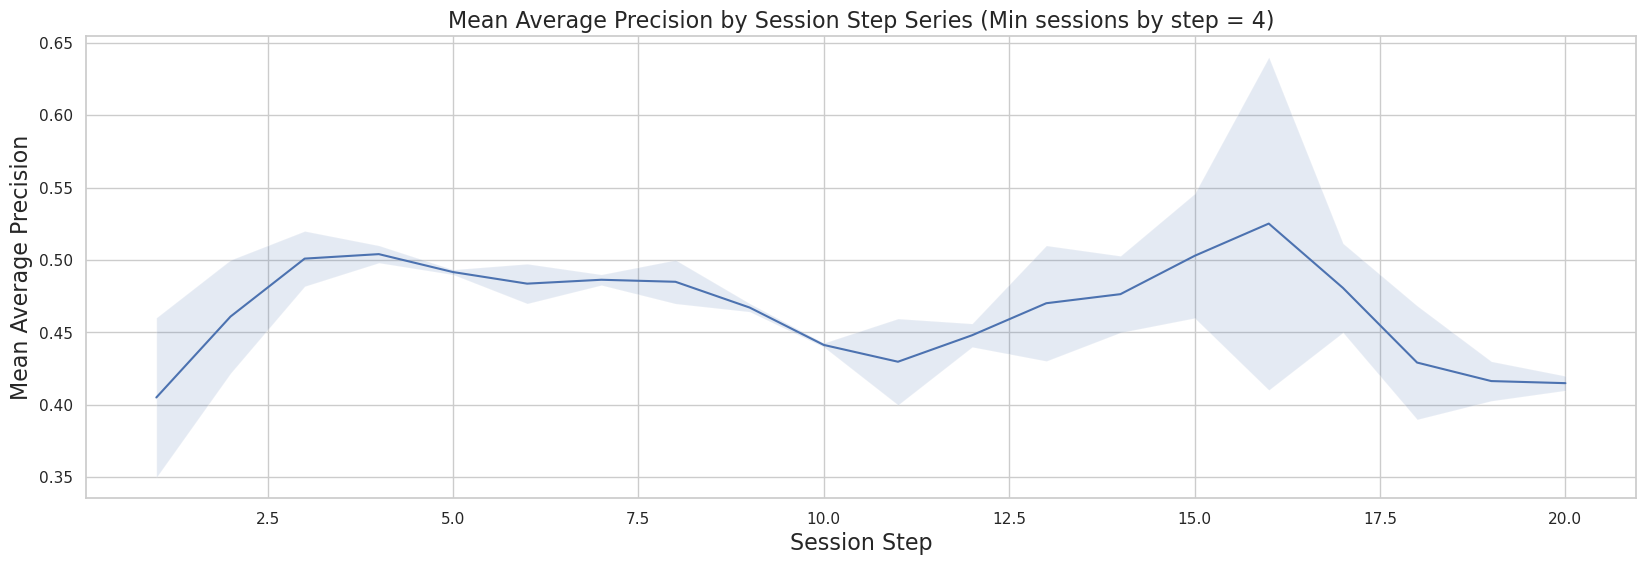

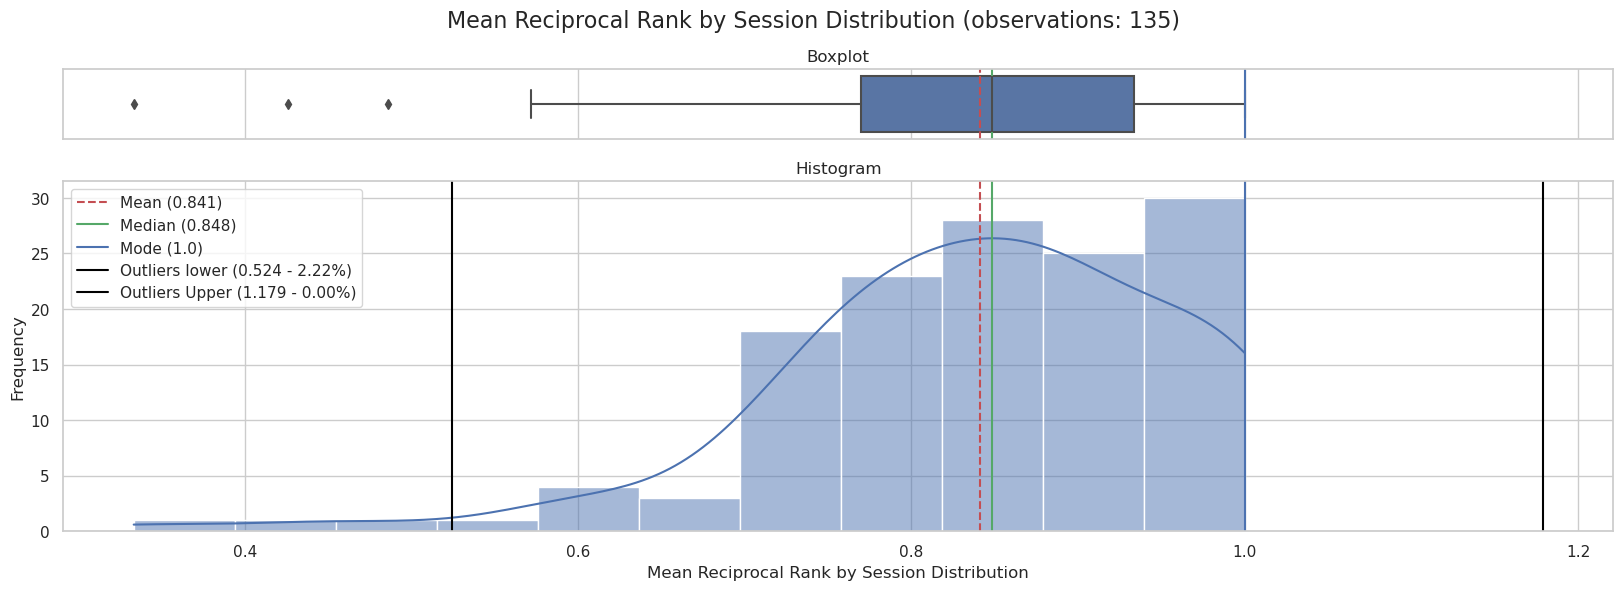

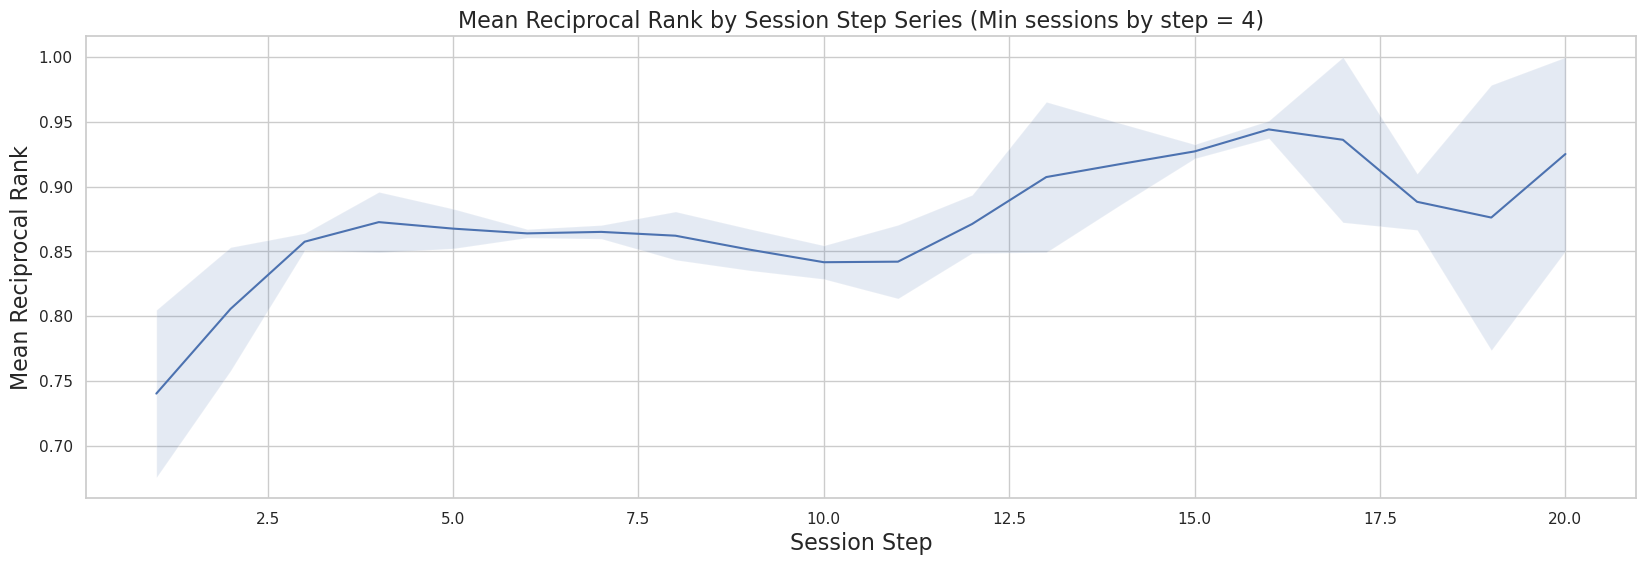

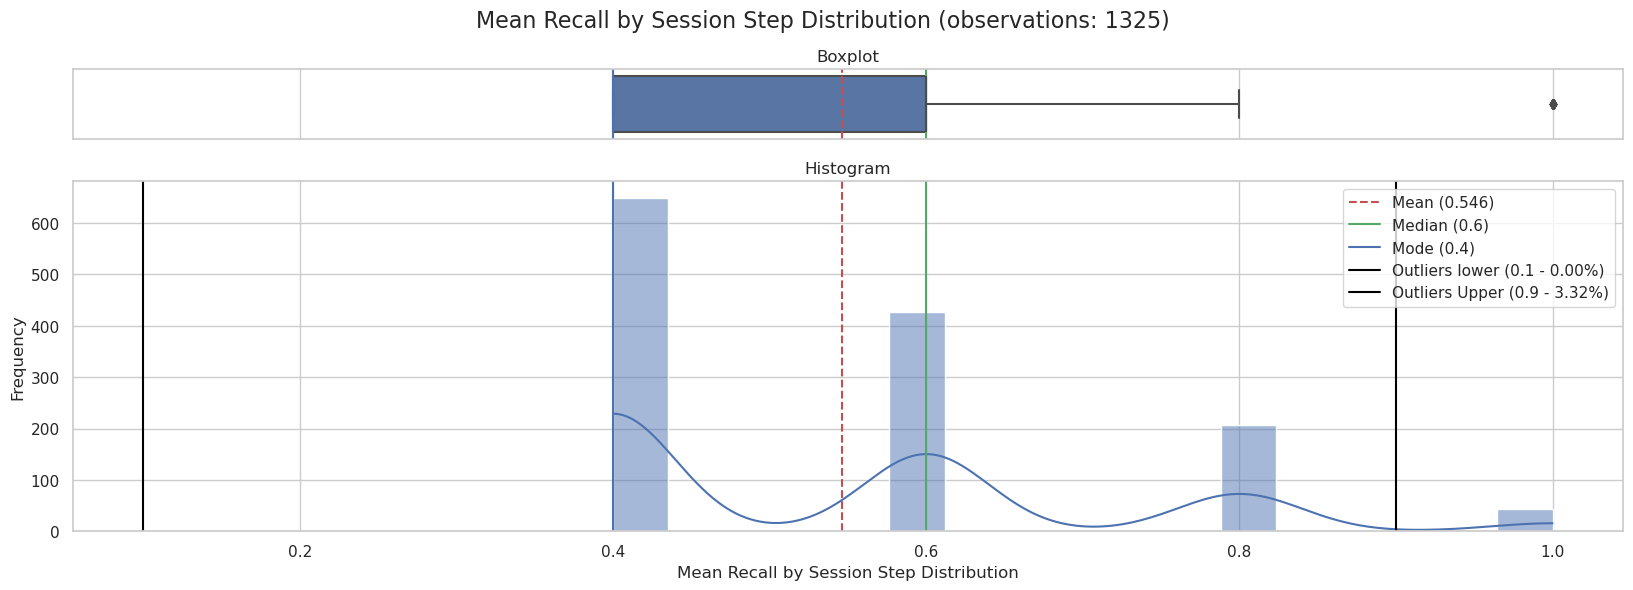

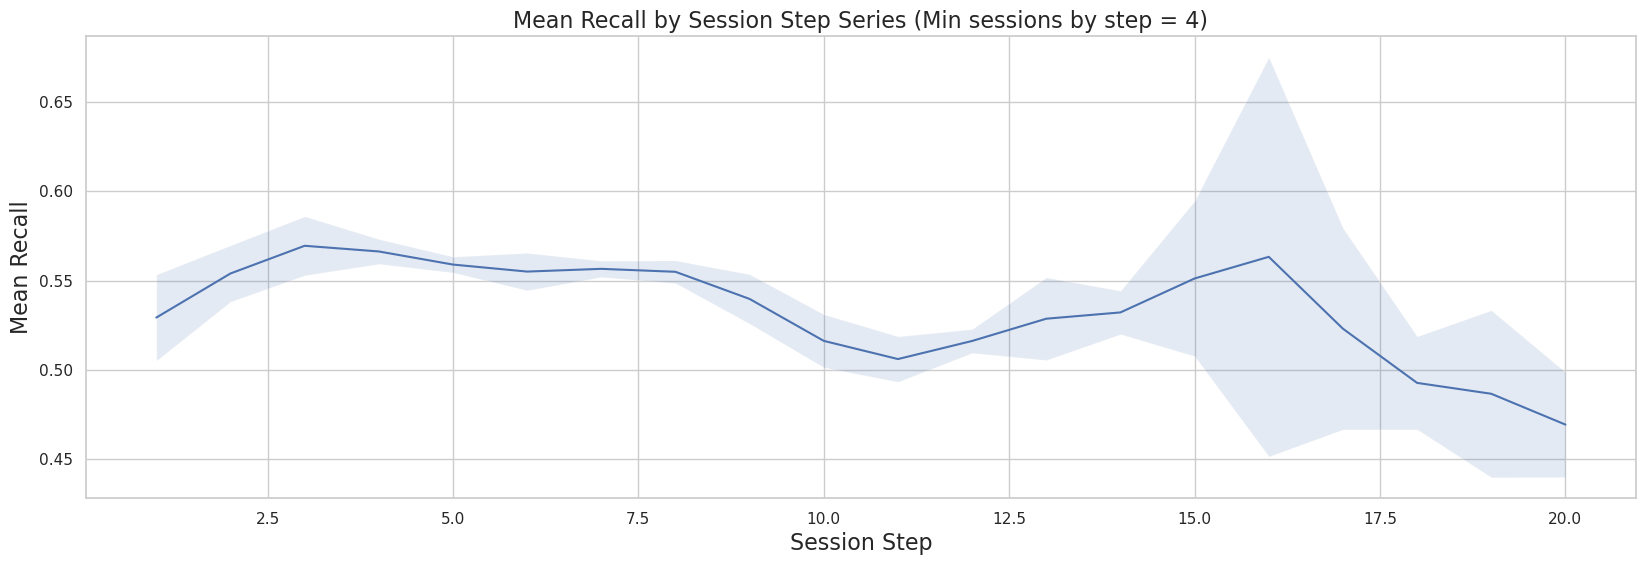

In [13]:
if RUN_EVALUATION:
    while True:
        evaluator.run()
else:
    evaluator_state = EvaluationState.load(EVAL_METRICS_PATH)
    evaluator_state.plot(
        item_ids=item_ids_resolver(), 
        save_path=f'{METRICS_PATH}/llama3-evaluation-metrics',
    )

Pendientes:
* Comparar el numero de sessiones por paso para cada modelo.